In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.cbook as cbook
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import xarray as xr
import numpy as np
import math
from numpy import *
from pylab import *
import pyproj

from siphon.catalog import TDSCatalog
from siphon.http_util import session_manager
from datetime import datetime, timedelta
from xarray.backends import NetCDF4DataStore
from netCDF4 import Dataset
import metpy as metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.units import units
from metpy.plots import add_metpy_logo, add_timestamp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy import config
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
import glob

In [2]:
pmsl_levels = np.arange(960, 1060, 4)
# dark brown for state/coastlines
dark_brown = (0.4, 0.2, 0)

#klevs correspond to plevs below for reference
#plevs  = [1000,950,900,850,800,750,700,650,600,55000.,50000.,45000.,
         #40000.,35000.,30000.,25000.,20000.,15000.,12500.,10000., 7500., 6000.]
plevs  = [100000.,95000.,90000.,85000.,80000.,75000.,70000.,65000.,60000.,55000.,50000.,45000.,
         40000.,35000.,30000.,25000.,20000.,15000.,12500.,10000., 7500., 6000.]
klev = 3#plevs[1:5]
level = plevs[klev]
print(level)
nlevs  = len(plevs)
hour = '12'
day = 8

85000.0


In [3]:
datafiles = (glob.glob(f"/scratch/sawyer/wwrf/2017-01-09/ishmael/wrfout_d01_2017-01-0{day}_{hour}:00:00"))
datafiles.sort()
numfiles=len(datafiles)
ncfile = Dataset(datafiles[0])
p = getvar(ncfile, "pressure")
# Get the lat/lon coordinates
wrf_lats, wrf_lons = latlon_coords(p)

## WWRF longitude fix ######
new_lons =np.where(wrf_lons > 0, wrf_lons - 360, wrf_lons)

# Sigma for gaussian filter setting for SLP
sigma = 3

In [4]:
# Initialize an empty list to store the filtered ivt arrays
pv_list = []
slp_list = []

# Get a list of all .npy files in the directory
file_paths = glob.glob(f'/scratch/sawyer/wwrf/2017-01-09/ensemble_data/pv/pvor/pvor_*_2017-01-0{day}_{hour}.npy')
slp_paths = glob.glob(f'/scratch/sawyer/wwrf/2017-01-09/ensemble_data/slp/slp_*_2017010{day}_{hour}.npy')

# Sort the file paths alphabetically
sorted_file_paths = sorted(file_paths)
# Loop through each file and load, filter, and append the data
for file in sorted_file_paths:
    print(file)
    pv_arrays = np.load(file, allow_pickle=True)
    pv_copy = pv_arrays.copy()
    pv_list.append(pv_copy)
    #print(ivt_arrays.shape)
sorted_slp_paths = sorted(slp_paths)
# Loop through each file and load, filter, and append the data
for file in sorted_slp_paths:
    print(file)
    slp_arrays = np.load(file, allow_pickle=True)
    slp = slp_arrays.copy()
    slp_array = gaussian_filter(slp, sigma)
    slp_list.append(slp_array)
    #print(ivt_arrays.shape)
    
# Initialize an empty list to store the filtered ivt arrays
lh_list = []
# Get a list of all .npy files in the directory
lh_paths = glob.glob(f'/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_latht/total_latht_*_2017010{day}_{hour}.npy')

# Sort the file paths alphabetically
sorted_lh_paths = sorted(lh_paths)
# Loop through each file and load, filter, and append the data
for lh in sorted_lh_paths:
    print(lh)
    lh_arrays = np.load(lh, allow_pickle=True)
    lh_copy = lh_arrays.copy()
    latht = np.zeros([569,618,nlevs])
    for k in range (nlevs):
        clev = plevs[k]/100.
        #print('interpolating to: ',clev)
        # Do vertical interpolation to specified pressure surfaces (in hPa)
        lat = interplevel(lh_copy, p, clev)
        latht[:,:,k] = lat
        
    lh_list.append(latht)
    
'''
# Initialize an empty list to store the filtered ivt arrays
ivt_list = []
# Get a list of all .npy files in the directory
ivt_paths = glob.glob(f'/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_*_2017010{day}_{hour}.npy')

# Sort the file paths alphabetically
sorted_ivt_paths = sorted(ivt_paths)
# Loop through each file and load, filter, and append the data
for ivt in sorted_ivt_paths:
    print(ivt)
    ivt_arrays = np.load(ivt, allow_pickle=True)
    ivt_copy = ivt_arrays.copy()
    ivt_copy = gaussian_filter(ivt_copy, 3)
    ivt_list.append(ivt_copy)
'''


/scratch/sawyer/wwrf/2017-01-09/ensemble_data/pv/pvor/pvor_ishmael_2017-01-08_12.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/pv/pvor/pvor_ntu_2017-01-08_12.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/pv/pvor/pvor_p3_1-cat_2017-01-08_12.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/pv/pvor/pvor_p3_2nd_2017-01-08_12.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/pv/pvor/pvor_p3_2x_cloud_2017-01-08_12.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/pv/pvor/pvor_p3_3mom_2017-01-08_12.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/pv/pvor/pvor_thompson_2017-01-08_12.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/pv/pvor/pvor_thompson_aa_38_2017-01-08_12.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/pv/pvor/pvor_wdm6_2017-01-08_12.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/pv/pvor/pvor_wsm6_2017-01-08_12.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/slp/slp_ishamel_20170108_12.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/slp/slp_ntu_20170108_12.

"\n# Initialize an empty list to store the filtered ivt arrays\nivt_list = []\n# Get a list of all .npy files in the directory\nivt_paths = glob.glob(f'/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_*_2017010{day}_{hour}.npy')\n\n# Sort the file paths alphabetically\nsorted_ivt_paths = sorted(ivt_paths)\n# Loop through each file and load, filter, and append the data\nfor ivt in sorted_ivt_paths:\n    print(ivt)\n    ivt_arrays = np.load(ivt, allow_pickle=True)\n    ivt_copy = ivt_arrays.copy()\n    ivt_copy = gaussian_filter(ivt_copy, 3)\n    ivt_list.append(ivt_copy)\n"

In [5]:
pv = []
lh = []
for i in range(len(pv_list)):
    # Sum over all desired levels
    summed_pv = np.sum(pv_list[i][:,:,2:7], axis=2)

    # Compute the 900 - 700 mb layer average
    pv_layer_avg = summed_pv / 5
    
    pv_ = pv_layer_avg *1000000.
    pv_=gaussian_filter(pv_, sigma=2)
    pv.append(pv_)

for i in range(len(lh_list)):
    # Sum over all desired levels
    summed_lh = lh_list[i][:,:,4]
    lh_ = summed_lh * 86400.
    lh_=gaussian_filter(lh_, sigma=6)
    lh.append(lh_)


(569, 618)
67.12083401285537
(569, 618)
40.12276323878428
(569, 618)
62.60233006513691
(569, 618)
74.33035899152546
(569, 618)
60.04303472096665
(569, 618)
68.26323136131755
(569, 618)
71.53397031929944
(569, 618)
59.76711428179938
(569, 618)
42.69807981897304
(569, 618)
51.21917589252011


In [6]:
print(len(pv_list))
# Make a list of title for plotting
titles = ['Ishmael','NTU','P3','P3 2nd', 'P3 2X', 'P3 3-mom',
          'Thompson', 'Thompson AA', 'WDM6', 'WSM6']
           #'WWRF Reanalysis']

10


In [7]:
pvlevs = np.arange(0.5,4.25,0.25)
# Load the reversed Viridis colormap
viridis_r = plt.cm.get_cmap('viridis', len(pvlevs))

# Create a new colormap by inserting white at the beginning
new_colors = viridis_r(np.linspace(0, 1, len(pvlevs)))
new_colors = np.vstack(([1, 1, 1, 1], new_colors))  # Insert white at the beginning

# Create the new colormap
viridis_w = ListedColormap(new_colors, name='modified_viridis')

ivtlevs = np.arange(250,1250,250)
cmap_name = 'red_to_darkred'
colors = [(1, 0.0, 0.0), (0.5, 0, 0)]  # This defines "red" and "dark red"
n_bins = 4  # This is the number of bins in your colormap

# Create the colormap
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
lhlevs = np.arange(5,60,10)

0
1
2
3
4
5
6
7
8
9


/tmp/ipykernel_52166/2802278035.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


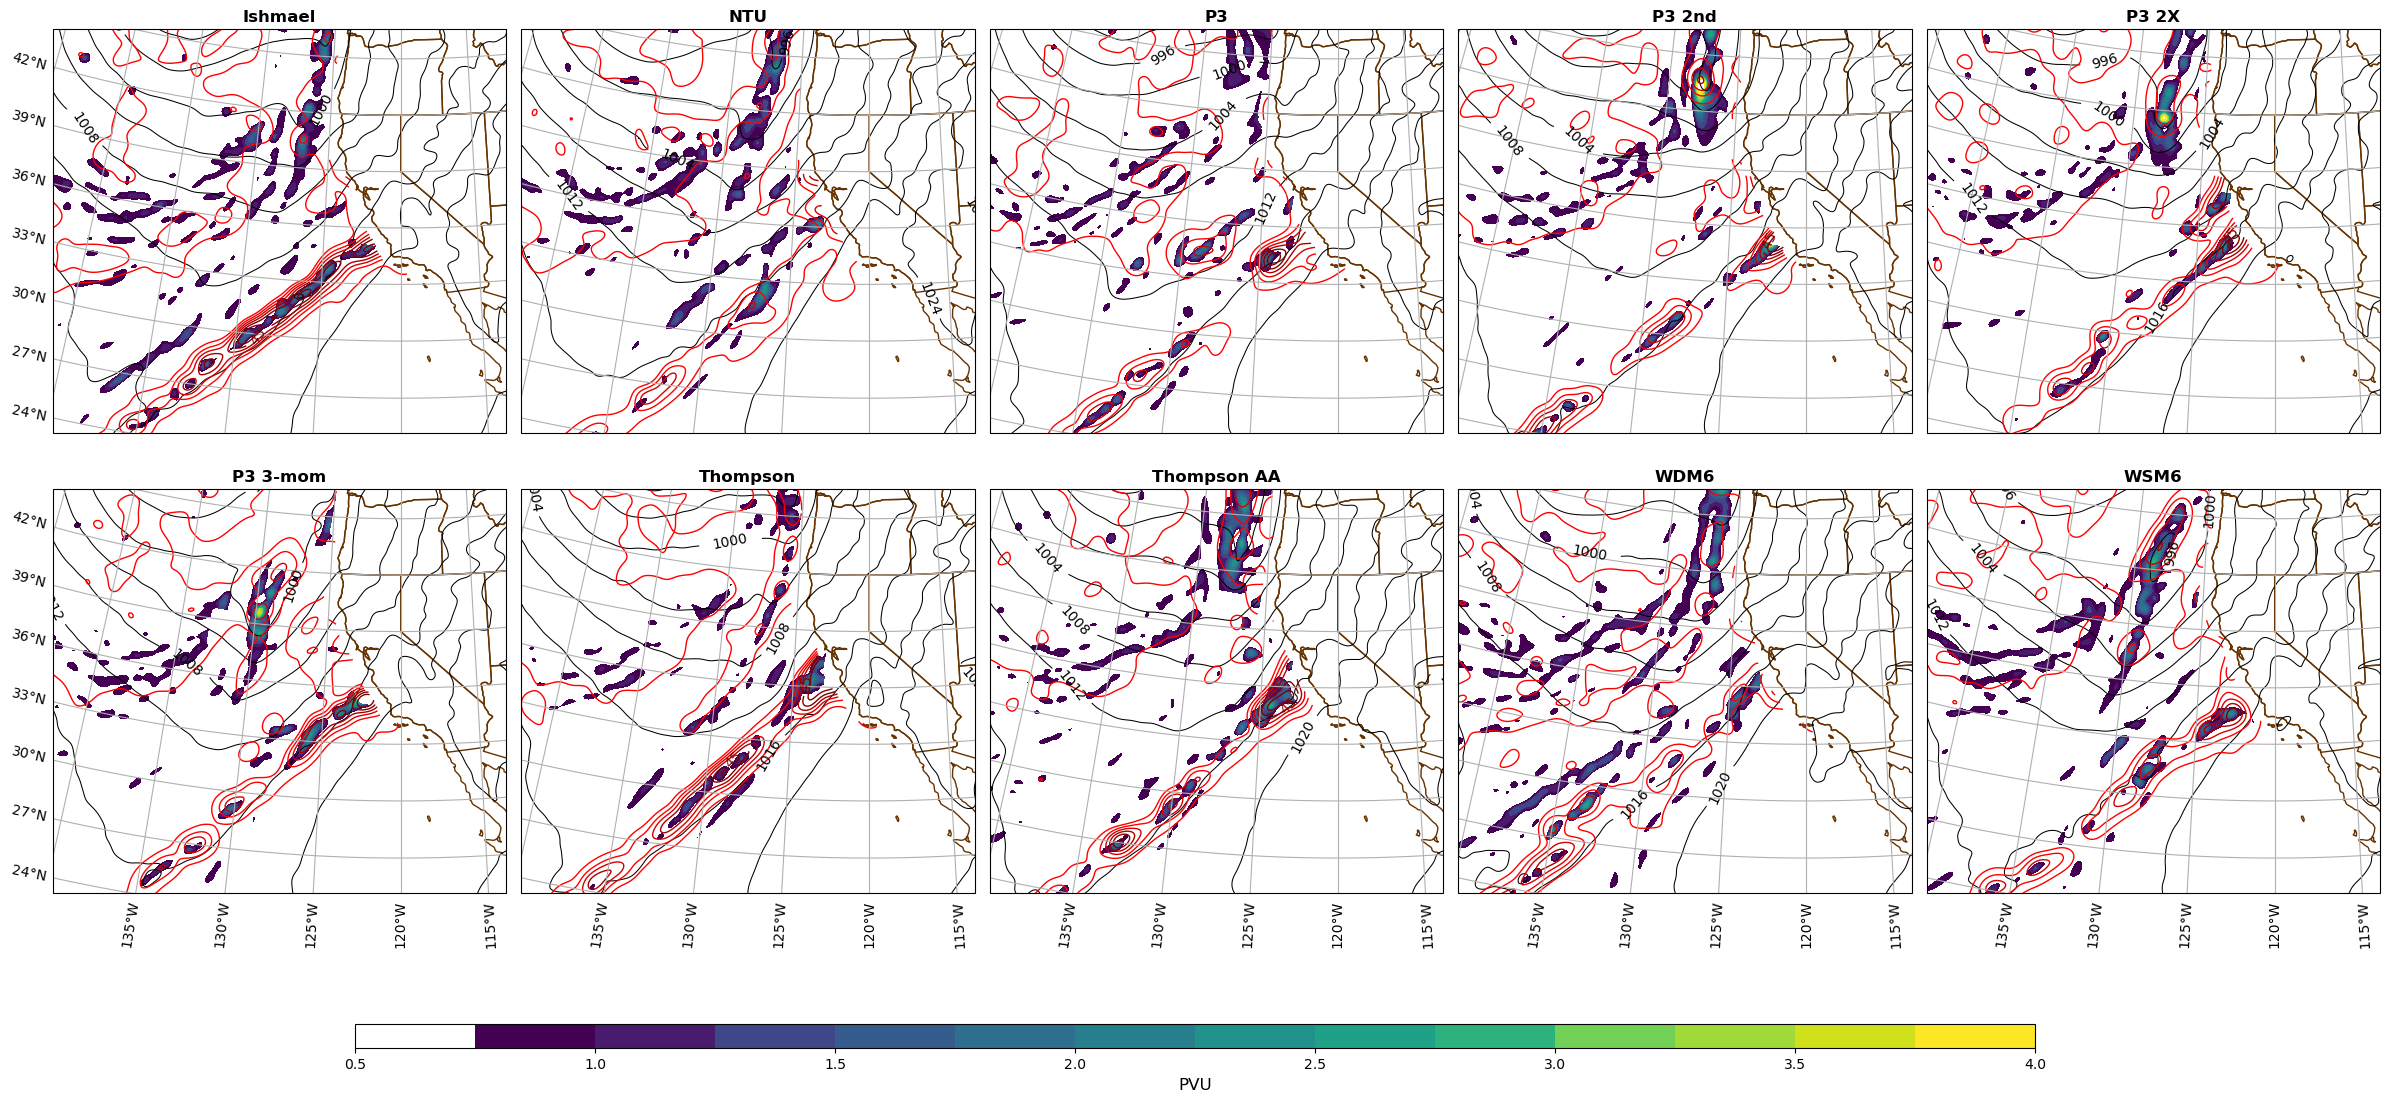

In [8]:
lcc_projection = ccrs.LambertConformal(
    central_longitude=-120.0)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(24, 12),
                        subplot_kw={'projection': lcc_projection})
axs = axs.ravel()  # Flatten axs

# Loop through the first N-1 elements
for i in range(len(pv_list)):#
    ax = axs[i]
    print(i)
    ax.set_extent([-140, -114, 25, 45])
    ax.add_feature(cfeature.COASTLINE, linewidth=1.0, edgecolor=dark_brown)
    ax.add_feature(cfeature.STATES, linewidth=1.0, edgecolor=dark_brown)
    ax.set_title(titles[i], fontweight='bold')



    cp1 = ax.contour(to_np(new_lons), to_np(wrf_lats), to_np(slp_list[i]),
                     colors = 'black',levels=pmsl_levels, linewidths=0.75, alpha=1,linestyles='-',transform=crs.PlateCarree())
    ax.clabel(cp1, fmt='%1.0f', inline=True,levels=pmsl_levels)
    
    cp2 = ax.contour(to_np(new_lons), to_np(wrf_lats), to_np(lh[i]),
                         cmap=cm ,levels=lhlevs,linewidths=1.,linestyles='-',transform=crs.PlateCarree())
    ax.clabel(cp2, fmt='%1.0f', inline=True,levels=[45])
    pvor_contours = ax.contourf(to_np(new_lons), to_np(wrf_lats), to_np(pv[i]), levels=pvlevs,#pvor[:,:,klev]
                          cmap=viridis_w,transform=crs.PlateCarree())
    
    
    
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels=False   # suppress top grid labels
    gl.right_labels=False # suppress right grid labels

    # Decide whether to show left and bottom labels based on subplot position
    # Show x labels only on the bottom row subplots
    if i < 5:  # Adjust the index based on your subplot ordering
        gl.bottom_labels = False
    # Show y labels only on the left column subplots
    if i % 5 != 0:  # Change the modulo based on your number of columns
        gl.left_labels = False
'''  
# Handle the last plot separately
ax = axs[len(ivt_list) - 1]
ax.set_extent([-140, -113, 25, 50])
ax.add_feature(cfeature.COASTLINE, linewidth=1.0, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=1.0, edgecolor='black')
ax.set_title(titles[-1], fontweight='bold')
cp = ax.contourf(to_np(lons), to_np(lat), to_np(ivt_list[-1]), cmap=cmap, 
                 levels=ivt_levels, transform=ccrs.PlateCarree())
cp2 = ax.contour(to_np(lons), to_np(lat), to_np(slp_list[-1]),
                         colors = 'black',levels=pmsl_levels, linewidths=.7, alpha=1,transform=crs.PlateCarree())
ax.clabel(cp2, fmt='%1.0f', inline=True,levels=pmsl_levels)

# Turn off any remaining subplots
for i in range(len(ivt_list), len(axs)):
    axs[i].axis('off')
'''
# Add a single colorbar at the bottom of the figure
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Adjust these dimensions to fit the colorbar nicely
cbar = fig.colorbar(pvor_contours, cax=cbar_ax, orientation='horizontal',extend='both')
#cbar = fig.colorbar(cp2, cax=cbar_ax, orientation='horizontal',extend='both')
cbar.set_label("PVU", fontsize = 12)

# Adjust layout
fig.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the colorbar

plt.savefig(f'900-700hPa_layer_avg_PV_800hPa_LH{hour}z_{day}Jan')
plt.show()